# JWST ETC Power-Law Profile Test

The JWST ETC has a [power-law profile](https://jwst-docs.stsci.edu/jwst-exposure-time-calculator-overview/jwst-etc-scenes-and-sources-page-overview/jwst-etc-defining-an-extended-source#JWSTETCDefininganExtendedSource-PowerLaw) for extended sources, defined as an `r**-k` profile with a small flat central core to avoid the singularity at `r=0`.  It accepts two parameters:

* Core radius in arcsec
* Power-law index

The normalization of the central core is in units of surface brightness, based on the source spectrum (continuum + lines, potentially including renormalization).

This notebook demonstrates an approach to defining cometary comae.






## Notebook setup

In [1]:
import numpy as np
from numpy import pi
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from sbpy.activity import Efrho

## Idealized coma profile

Assume a 1/ρ coma profile, generate an image, and plot the radial profile of the image.

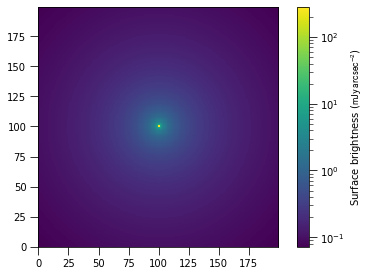

In [2]:
pixel_scale = 0.1 * u.mas

y, x = np.mgrid[-100:100, -100:100] * pixel_scale
rho = np.hypot(y, x)
# center pixel distance is mean distance to the pixel's center (approximate)
rho[100, 100] = np.sqrt(2) / 4 / 10 * pixel_scale

# dropping units on rho to make sure coma has units mJy/arcsec**2
coma = 1 / rho.value * u.mJy / u.arcsec**2

plt.imshow(coma.value, norm=mpl.colors.LogNorm(), interpolation='nearest')
plt.colorbar(label=f'Surface brightness ({coma.unit:latex_inline})')

[None,
 Text(0, 0.5, 'Surface brightness ($\\mathrm{mJy\\,arcsec^{-2}}$)'),
 None,
 Text(0.5, 0, '$ρ$ (mas)')]

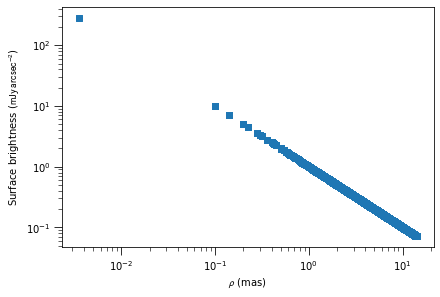

In [3]:
plt.scatter(rho.ravel(), coma.ravel(), marker=',')
plt.setp(plt.gca(), yscale='log', xscale='log',
         ylabel=f'Surface brightness ({coma.unit:latex_inline})',
         xlabel=f'$ρ$ ({rho.unit})')

# ETC power-law profile

Generate an ETC power-law profile that matches the above surface brightness distribution outside of the flat-disk core.

Let, `core_sb` be the surface brightness inside the core.  Assume that the ETC profile is continuous, such that surface brightness at the edge of the core matches the power-law profile thereafter.  Thus, the surface brightness outside of the core is `core_sb * (rho / core_rho)**-k`

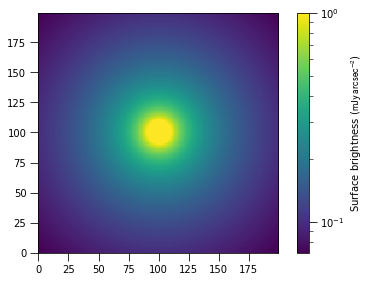

In [4]:
k = 1
core_rho = 1 * u.mas
core_sb = 1.0 * u.mJy / u.arcsec**2
coma_etc = core_sb * (rho / core_rho)**-k
coma_etc[rho <= core_rho] = core_sb

plt.imshow(coma_etc.value, norm=mpl.colors.LogNorm(), interpolation='nearest')
plt.colorbar(label=f'Surface brightness ({coma.unit:latex_inline})')

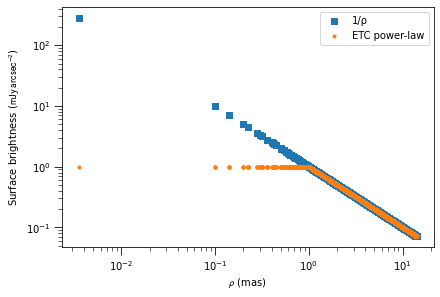

In [5]:
plt.scatter(rho.ravel(), coma.ravel(), marker=',', label='1/ρ')
plt.scatter(rho.ravel(), coma_etc.ravel(), marker='.', label='ETC power-law')
plt.setp(plt.gca(), yscale='log', xscale='log',
         ylabel=f'Surface brightness ({coma.unit:latex_inline})',
         xlabel=f'$ρ$ ({rho.unit})')
plt.legend()

## Coma flux density estimates

Our coma flux density estimation tools generally predict the total flux density within an aperture size (radius or diameter).  What size do we provide the tool in order to generate an ETC profile with the expected total flux?

1. Make a dust coma model for a 10-mas radius aperture.
1. Generate a new ideal coma that matches the estimate.
1. Generate a new ETC power-law profile.
1. Calculate the surface brightness of the core.
1. Estimate the coma model radius needed to predict that core surface brightness.

In [6]:
# We use the εfρ model of Kelley et al. 2013
efrho = Efrho(1000 * u.cm)

wave = 8 * u.um
rap = 10 * u.mas  # photometric aperture radius
eph = {'rh': 2 * u.au, 'delta': 1.5 * u.au}
unit = 'mJy'

fluxd = efrho.to_fluxd(wave, rap, eph, unit=unit)
print(f'Dust coma flux density is {fluxd:.3f} within {rap} radius aperture.')

Dust coma flux density is 0.129 mJy within 10.0 mas radius aperture.


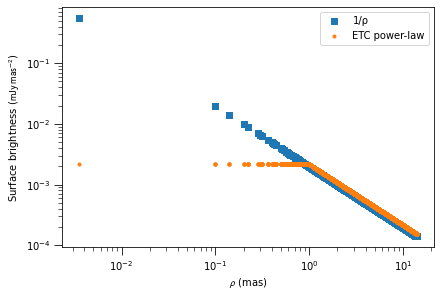

In [7]:
# ideal coma
coma = 1 / rho.value * u.mJy / u.arcsec**2
# sum is really an integral over area, need to account for that with the pixel scale
coma = coma * fluxd / coma[rho <= rap].sum() / pixel_scale**2

# ETC coma
core_sb = 1.0 * u.mJy / u.arcsec**2 # arbitrary
core_rho = 1.0 * u.mas # mas
coma_etc = core_sb * (rho / core_rho)**-k
coma_etc[rho <= core_rho] = core_sb
coma_etc = coma_etc * fluxd / coma_etc[rho <= rap].sum() / pixel_scale**2

plt.scatter(rho.ravel(), coma.ravel(), marker=',', label='1/ρ')
plt.scatter(rho.ravel(), coma_etc.ravel(), marker='.', label='ETC power-law')
plt.setp(plt.gca(), yscale='log', xscale='log', 
         ylabel=f'Surface brightness ({coma.unit:latex_inline})',
         xlabel=f'$ρ$ ({rho.unit})')
plt.legend()

In [8]:
core_sb = coma_etc.max().to('mJy/arcsec2')
print(f'The surface brightness of the ETC disk is {core_sb:.3g}.')

The surface brightness of the ETC disk is 2.16e+03 mJy / arcsec2.


Total flux within an aperture for an ideal coma is directly proportional to aperture size, and surface brightness is inversely proportional to aperture size.  What aperture size yields `core_sb`?

In [9]:
sb = (fluxd / pi / rap**2).to('mJy/arcsec2')
rap_est = (rap * sb / core_sb)
fluxd_est = efrho.to_fluxd(wave, rap_est, eph, unit=unit)

print(f'''
Coma dust model:
  Total flux density within {rap} = {fluxd:.3g}
  → Surface brightness = {sb:.3g}

ETC profile:
  Core surface brightness = {core_sb:.3g}

Coma dust model is too bright by a factor of {sb / core_sb}

Coma dust model surface brigthness scales inversely with aperture radius.

Use an aperture radius of {rap_est:.2f} for an ETC core radius of {core_rho}.

This result is slightly smaller than 2.0 due to the relative size of the ETC core and the
photometric aperture.  As the photometric aperture increases, the radius ratio needed to reproduce
the desired ETC core surface brightness asymptotes to 2.0.  For typical JWST pixel sizes (>1 NIRCam
pixel = 32 mas) and a core radius of 1 mas, the error introduced by using `2 * core_rho` is likely
not signficant.

''')


Coma dust model:
  Total flux density within 10.0 mas = 0.129 mJy
  → Surface brightness = 410 mJy / arcsec2

ETC profile:
  Core surface brightness = 2.16e+03 mJy / arcsec2

Coma dust model is too bright by a factor of 0.18997465062068242

Coma dust model surface brigthness scales inversely with aperture radius.

Use an aperture radius of 1.90 mas for an ETC core radius of 1.0 mas.

This result is slightly smaller than 2.0 due to the relative size of the ETC core and the
photometric aperture.  As the photometric aperture increases, the radius ratio needed to reproduce
the desired ETC core surface brightness asymptotes to 2.0.  For typical JWST pixel sizes (>1 NIRCam
pixel = 32 mas) and a core radius of 1 mas, the error introduced by using `2 * core_rho` is likely
not signficant.




## Verify the results

We want to model a coma within an aperture radius of 1 NIRSpec pixel = 0.11 arcsec.

Generate the goal 1/ρ coma and the ETC profile to match it.

In [10]:
# We use the εfρ model of Kelley et al. 2013
efrho = Efrho(5000 * u.cm)

wave = 8 * u.um
rap = 0.11 * u.mas  # photometric aperture radius
eph = {'rh': 2 * u.au, 'delta': 1.5 * u.au}
unit = 'mJy'

fluxd = efrho.to_fluxd(wave, rap, eph, unit=unit)

# ideal coma
coma = 1 / rho.value * u.mJy / u.arcsec**2
# sum is really an integral over area, need to account for that with the pixel scale
coma = coma * fluxd / coma[rho <= rap].sum() / pixel_scale**2

# ETC coma
k = 1
core_rho = 1 * u.mas
rap_etc = core_rho * 2.0
fluxd_etc = efrho.to_fluxd(wave, rap_est, eph, unit=unit)
core_sb = fluxd_etc / pi / rap_etc**2

coma_etc = core_sb * (rho / core_rho)**-k
coma_etc[rho <= core_rho] = core_sb
coma_etc = coma_etc * fluxd / coma_etc[rho <= rap].sum() / pixel_scale**2

# verify
coma_test = (coma[rho <= rap].sum() * pixel_scale**2).to('mJy')
coma_etc_test = (coma_etc[rho <= rap].sum() * pixel_scale**2).to('mJy')

print(f'''
Goal dust coma flux density is {fluxd:.3g} within {rap} radius aperture.

Generated 1/ρ coma yields a flux density of {coma_test:.3g}.

Generated ETC power-law profile yields a flux density of {coma_etc_test:.3g}.
''')


Goal dust coma flux density is 0.00708 mJy within 0.11 mas radius aperture.

Generated 1/ρ coma yields a flux density of 0.00708 mJy.

Generated ETC power-law profile yields a flux density of 0.00708 mJy.

